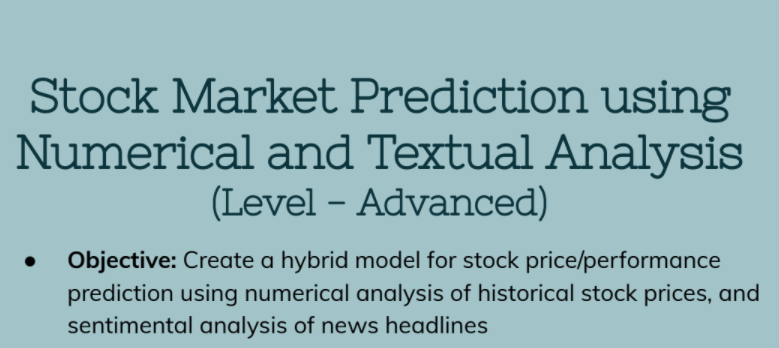

In [2]:
nltk.download('vader_lexicon')

<IPython.core.display.Javascript object>

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\punit\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### Importing Required Libraries

In [3]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Dense, Activation
import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler
from nltk.sentiment.vader import SentimentIntensityAnalyzer

### Reading the data and doing the EDA

In [4]:
stock_price = pd.read_csv('RELIANCE.csv')
news_headline = pd.read_csv('india-news-headlines.csv')

In [5]:
stock_price = stock_price.drop(['Trades','Deliverable Volume','%Deliverble','VWAP','Series','Symbol','Prev Close','Turnover'],axis = 1)

In [6]:
stock_price.head()

,Date,Open,High,Low,Last,Close,Volume
0,2000-01-03,237.50,251.70,237.50,251.70,251.70,4456424
1,2000-01-04,258.40,271.85,251.30,271.85,271.85,9487878
2,2000-01-05,256.65,287.90,256.65,286.75,282.50,26833684
3,2000-01-06,289.00,300.70,289.00,293.50,294.35,15682286
4,2000-01-07,295.00,317.90,293.00,314.50,314.55,19870977


In [7]:
news_headline.head()

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


In [8]:
stock_price.isna().any(), news_headline.isna().any()

(Date      False
 Open      False
 High      False
 Low       False
 Last      False
 Close     False
 Volume    False
 dtype: bool,
 publish_date         False
 headline_category    False
 headline_text        False
 dtype: bool)

In [9]:
stock_price['Date'] = pd.to_datetime(stock_price['Date']).dt.normalize()
stock_price.set_index('Date', inplace= True)
stock_price = stock_price.sort_index(ascending=True, axis=0)
stock_price

,Open,High,Low,Last,Close,Volume
Date,,,,,,
2000-01-03,237.50,251.70,237.50,251.70,251.70,4456424
2000-01-04,258.40,271.85,251.30,271.85,271.85,9487878
2000-01-05,256.65,287.90,256.65,286.75,282.50,26833684
2000-01-06,289.00,300.70,289.00,293.50,294.35,15682286
2000-01-07,295.00,317.90,293.00,314.50,314.55,19870977
...,...,...,...,...,...,...
2021-04-26,1920.00,1962.00,1911.50,1938.00,1937.85,9620785
2021-04-27,1940.00,1997.20,1938.25,1990.00,1988.65,9226547
2021-04-28,1997.85,2008.00,1980.15,1993.15,1997.30,7902002


In [10]:
news_headline = news_headline.drop_duplicates()
news_headline['publish_date'] = news_headline['publish_date'].astype(str)
news_headline['publish_date'] = news_headline['publish_date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])
news_headline['publish_date'] = pd.to_datetime(news_headline['publish_date']).dt.normalize()
news_headline = news_headline.filter(['publish_date', 'headline_text'])
news_headline = news_headline.groupby(['publish_date'])['headline_text'].apply(lambda x: ','.join(x)).reset_index()
news_headline.set_index('publish_date', inplace= True)
news_headline = news_headline.sort_index(ascending=True, axis=0)
news_headline

,headline_text
publish_date,
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,"Powerless north India gropes in the dark,Think..."
2001-01-04,The string that pulled Stephen Hawking to Indi...
2001-01-05,Light combat craft takes India into club class...
2001-01-06,Light combat craft takes India into club class...
...,...
2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...
2020-12-28,Horoscope Today; 28 December 2020: Check astro...
2020-12-29,Man recovers charred remains of 'thief' from h...


In [11]:
stock_data = pd.concat([stock_price, news_headline], axis=1)
stock_data.dropna(axis=0, inplace=True)
stock_data

,Open,High,Low,Last,Close,Volume,headline_text
2001-01-02,340.35,359.00,340.25,358.10,354.30,6623970.0,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,355.00,361.70,353.00,358.20,360.05,8844088.0,"Powerless north India gropes in the dark,Think..."
2001-01-04,359.10,366.90,356.20,357.00,357.80,5982701.0,The string that pulled Stephen Hawking to Indi...
2001-01-05,356.50,366.80,356.50,363.40,364.30,7460148.0,Light combat craft takes India into club class...
2001-01-08,362.50,367.45,357.25,358.00,360.20,6842731.0,"Sangh Parivar; Babri panel up the ante,Frontru..."
...,...,...,...,...,...,...,...
2020-12-24,1947.00,1998.80,1945.90,1992.95,1994.15,9588577.0,How to set the mood for sex during cold winter...
2020-12-28,2006.70,2018.00,1995.30,2002.00,2003.30,7947719.0,Horoscope Today; 28 December 2020: Check astro...
2020-12-29,2009.00,2012.30,1982.55,1987.00,1990.05,8589407.0,Man recovers charred remains of 'thief' from h...
2020-12-30,1995.25,2007.20,1975.55,1994.35,1995.50,10173132.0,Numerology Readings 30 December 2020: Predicti...


In [12]:
stock_data['compound'] = ''
stock_data['negative'] = ''
stock_data['neutral'] = ''
stock_data['positive'] = ''
stock_data.head()

,Open,High,Low,Last,Close,Volume,headline_text,compound,negative,neutral,positive
2001-01-02,340.35,359.00,340.25,358.1,354.30,6623970.0,Status quo will not be disturbed at Ayodhya; s...,,,,
2001-01-03,355.00,361.70,353.00,358.2,360.05,8844088.0,"Powerless north India gropes in the dark,Think...",,,,
2001-01-04,359.10,366.90,356.20,357.0,357.80,5982701.0,The string that pulled Stephen Hawking to Indi...,,,,
2001-01-05,356.50,366.80,356.50,363.4,364.30,7460148.0,Light combat craft takes India into club class...,,,,
2001-01-08,362.50,367.45,357.25,358.0,360.20,6842731.0,"Sangh Parivar; Babri panel up the ante,Frontru...",,,,


### Doing the sentimental analysis and calculating compound,positive,neutral,negative

In [13]:
sid = SentimentIntensityAnalyzer()
stock_data['compound'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['compound'])
stock_data['negative'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neg'])
stock_data['neutral'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neu'])
stock_data['positive'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['pos'])
stock_data.head()

,Open,High,Low,Last,Close,Volume,headline_text,compound,negative,neutral,positive
2001-01-02,340.35,359.00,340.25,358.1,354.30,6623970.0,Status quo will not be disturbed at Ayodhya; s...,-0.9621,0.119,0.817,0.064
2001-01-03,355.00,361.70,353.00,358.2,360.05,8844088.0,"Powerless north India gropes in the dark,Think...",0.6322,0.084,0.817,0.098
2001-01-04,359.10,366.90,356.20,357.0,357.80,5982701.0,The string that pulled Stephen Hawking to Indi...,0.6648,0.077,0.843,0.080
2001-01-05,356.50,366.80,356.50,363.4,364.30,7460148.0,Light combat craft takes India into club class...,0.9253,0.104,0.744,0.152
2001-01-08,362.50,367.45,357.25,358.0,360.20,6842731.0,"Sangh Parivar; Babri panel up the ante,Frontru...",-0.9638,0.119,0.855,0.026


In [14]:
stock_data

,Open,High,Low,Last,Close,Volume,headline_text,compound,negative,neutral,positive
2001-01-02,340.35,359.00,340.25,358.10,354.30,6623970.0,Status quo will not be disturbed at Ayodhya; s...,-0.9621,0.119,0.817,0.064
2001-01-03,355.00,361.70,353.00,358.20,360.05,8844088.0,"Powerless north India gropes in the dark,Think...",0.6322,0.084,0.817,0.098
2001-01-04,359.10,366.90,356.20,357.00,357.80,5982701.0,The string that pulled Stephen Hawking to Indi...,0.6648,0.077,0.843,0.080
2001-01-05,356.50,366.80,356.50,363.40,364.30,7460148.0,Light combat craft takes India into club class...,0.9253,0.104,0.744,0.152
2001-01-08,362.50,367.45,357.25,358.00,360.20,6842731.0,"Sangh Parivar; Babri panel up the ante,Frontru...",-0.9638,0.119,0.855,0.026
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,1947.00,1998.80,1945.90,1992.95,1994.15,9588577.0,How to set the mood for sex during cold winter...,-0.9971,0.082,0.854,0.064
2020-12-28,2006.70,2018.00,1995.30,2002.00,2003.30,7947719.0,Horoscope Today; 28 December 2020: Check astro...,-0.9997,0.126,0.789,0.085
2020-12-29,2009.00,2012.30,1982.55,1987.00,1990.05,8589407.0,Man recovers charred remains of 'thief' from h...,-0.9998,0.136,0.774,0.090
2020-12-30,1995.25,2007.20,1975.55,1994.35,1995.50,10173132.0,Numerology Readings 30 December 2020: Predicti...,-0.9998,0.126,0.797,0.077


In [15]:
stock_data = stock_data[['Close', 'compound', 'negative', 'neutral', 'positive', 'Open', 'High', 'Low', 'Volume']]
stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2001-01-02,354.30,-0.9621,0.119,0.817,0.064,340.35,359.00,340.25,6623970.0
2001-01-03,360.05,0.6322,0.084,0.817,0.098,355.00,361.70,353.00,8844088.0
2001-01-04,357.80,0.6648,0.077,0.843,0.080,359.10,366.90,356.20,5982701.0
2001-01-05,364.30,0.9253,0.104,0.744,0.152,356.50,366.80,356.50,7460148.0
2001-01-08,360.20,-0.9638,0.119,0.855,0.026,362.50,367.45,357.25,6842731.0


In [16]:
stock_data.to_csv('stock_data.csv')

In [17]:
stock_data = pd.read_csv('stock_data.csv', index_col = False)
stock_data.rename(columns={'Unnamed: 0':'Date'}, inplace = True)
stock_data.set_index('Date', inplace=True)
stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2001-01-02,354.30,-0.9621,0.119,0.817,0.064,340.35,359.00,340.25,6623970.0
2001-01-03,360.05,0.6322,0.084,0.817,0.098,355.00,361.70,353.00,8844088.0
2001-01-04,357.80,0.6648,0.077,0.843,0.080,359.10,366.90,356.20,5982701.0
2001-01-05,364.30,0.9253,0.104,0.744,0.152,356.50,366.80,356.50,7460148.0
2001-01-08,360.20,-0.9638,0.119,0.855,0.026,362.50,367.45,357.25,6842731.0


### Plotting the close price graph

Text(0, 0.5, 'Close Price (Rs.)')

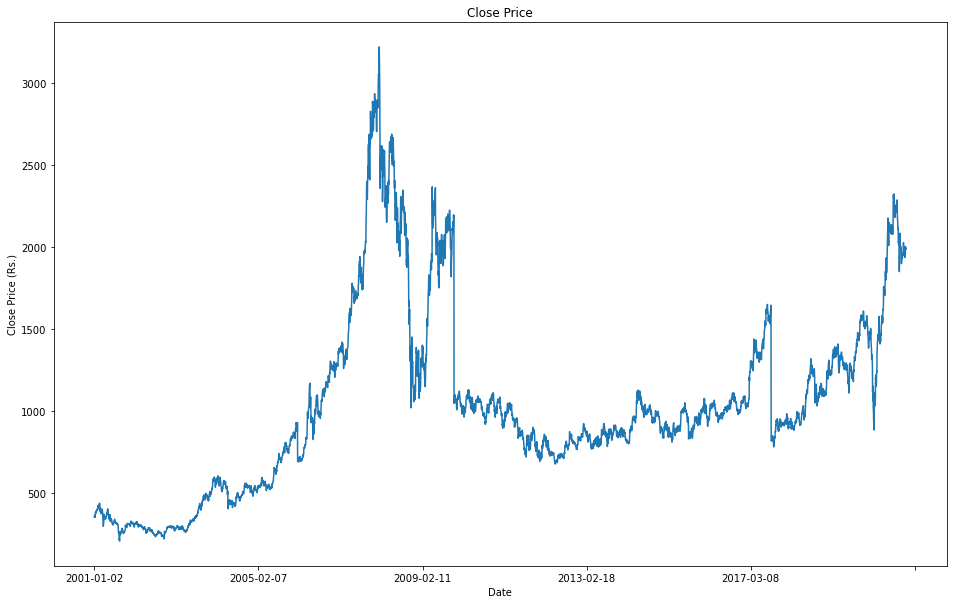

In [18]:
plt.figure(figsize=(16,10))
stock_data['Close'].plot()
plt.title("Close Price")
plt.xlabel('Date')
plt.ylabel('Close Price (Rs.)')

### Distributing the data for training and testing

In [19]:
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(stock_data)-1))
train_end = int(data_to_use*0.85)
total_data = len(stock_data)
start = total_data - data_to_use
print("Number of records in Training Data:", train_end)
print("Number of records in Test Data:", total_data - train_end)

Number of records in Training Data: 4203
Number of records in Test Data: 743


In [20]:
steps_to_predict = 1
close_price = stock_data.iloc[start:total_data,0] 
compound = stock_data.iloc[start:total_data,1]
negative = stock_data.iloc[start:total_data,2] 
neutral = stock_data.iloc[start:total_data,3] 
positive = stock_data.iloc[start:total_data,4]
open_price = stock_data.iloc[start:total_data,5] 
high = stock_data.iloc[start:total_data,6] 
low = stock_data.iloc[start:total_data,7] 
volume = stock_data.iloc[start:total_data,8] 
print("Close Price:")
close_price

Close Price:


Date
2001-01-03     360.05
2001-01-04     357.80
2001-01-05     364.30
2001-01-08     360.20
2001-01-09     357.95
               ...   
2020-12-24    1994.15
2020-12-28    2003.30
2020-12-29    1990.05
2020-12-30    1995.50
2020-12-31    1985.30
Name: Close, Length: 4945, dtype: float64

In [21]:
close_price_shifted = close_price.shift(-1) 
compound_shifted = compound.shift(-1) 
data = pd.concat([close_price, close_price_shifted, compound, compound_shifted, volume, open_price, high, low], axis=1)
data.columns = ['close_price', 'close_price_shifted', 'compound', 'compound_shifted','volume', 'open_price', 'high', 'low']
data = data.dropna()    
data.head(10)

,close_price,close_price_shifted,compound,compound_shifted,volume,open_price,high,low
Date,,,,,,,,
2001-01-03,360.05,357.80,0.6322,0.6648,8844088.0,355.00,361.70,353.00
2001-01-04,357.80,364.30,0.6648,0.9253,5982701.0,359.10,366.90,356.20
2001-01-05,364.30,360.20,0.9253,-0.9638,7460148.0,356.50,366.80,356.50
2001-01-08,360.20,357.95,-0.9638,-0.9559,6842731.0,362.50,367.45,357.25
2001-01-09,357.95,351.70,-0.9559,-0.5719,4513682.0,359.40,361.80,357.10
2001-01-10,351.70,381.65,-0.5719,0.9295,4730779.0,358.55,361.45,349.15
2001-01-23,381.65,380.35,0.9295,-0.9039,8274005.0,374.75,384.25,374.75
2001-01-24,380.35,381.70,-0.9039,-0.9838,5461105.0,384.40,384.50,378.50
2001-01-25,381.70,377.65,-0.9838,0.9697,4489764.0,381.50,383.50,376.65


### Setting the target variable

In [22]:
y = data['close_price_shifted']
y

Date
2001-01-03     357.80
2001-01-04     364.30
2001-01-05     360.20
2001-01-08     357.95
2001-01-09     351.70
               ...   
2020-12-23    1994.15
2020-12-24    2003.30
2020-12-28    1990.05
2020-12-29    1995.50
2020-12-30    1985.30
Name: close_price_shifted, Length: 4944, dtype: float64

In [23]:
cols = ['close_price', 'compound', 'compound_shifted', 'volume', 'open_price', 'high', 'low']
x = data[cols]
x

,close_price,compound,compound_shifted,volume,open_price,high,low
Date,,,,,,,
2001-01-03,360.05,0.6322,0.6648,8844088.0,355.00,361.70,353.00
2001-01-04,357.80,0.6648,0.9253,5982701.0,359.10,366.90,356.20
2001-01-05,364.30,0.9253,-0.9638,7460148.0,356.50,366.80,356.50
2001-01-08,360.20,-0.9638,-0.9559,6842731.0,362.50,367.45,357.25
2001-01-09,357.95,-0.9559,-0.5719,4513682.0,359.40,361.80,357.10
...,...,...,...,...,...,...,...
2020-12-23,1943.85,-0.9996,-0.9971,8999898.0,1930.00,1951.45,1920.65
2020-12-24,1994.15,-0.9971,-0.9997,9588577.0,1947.00,1998.80,1945.90
2020-12-28,2003.30,-0.9997,-0.9998,7947719.0,2006.70,2018.00,1995.30


In [47]:
scaler_x = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)
scaler_y = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y = np.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)
x[0:5], y

(array([[-0.89818363,  0.6322    ,  0.6648    , -0.73023848, -0.90602636,
         -0.91078285, -0.89828778],
        [-0.89967654,  0.6648    ,  0.9253    , -0.81804062, -0.903371  ,
         -0.90739897, -0.8961092 ],
        [-0.89536369,  0.9253    , -0.9638    , -0.77270491, -0.90505489,
         -0.90746405, -0.89590496],
        [-0.8980841 , -0.9638    , -0.9559    , -0.79165046, -0.901169  ,
         -0.90704106, -0.89539436],
        [-0.89957701, -0.9559    , -0.5719    , -0.86311771, -0.90317671,
         -0.91071777, -0.89549648]]),
 array([[-0.89967654],
        [-0.89536369],
        [-0.8980841 ],
        ...,
        [ 0.18334577],
        [ 0.18696193],
        [ 0.18019408]]))

### Splitting the data into train and test data

In [25]:
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  
print('Number of rows and columns in the Training set X:', X_train.shape, 'and y:', y_train.shape)
print('Number of rows and columns in the Test set X:', X_test.shape, 'and y:', y_test.shape)

Number of rows and columns in the Training set X: (4203, 7) and y: (4203, 1)
Number of rows and columns in the Test set X: (740, 7) and y: (740, 1)


In [26]:
X_train = X_train.reshape (X_train.shape + (1,)) 
X_test = X_test.reshape(X_test.shape + (1,))
print('Shape of Training set X:', X_train.shape)
print('Shape of Test set X:', X_test.shape)

Shape of Training set X: (4203, 7, 1)
Shape of Test set X: (740, 7, 1)


### Creating the LSTM model for prediciton of stock prices

In [27]:
np.random.seed(2016)
model=Sequential()
model.add(LSTM(100,return_sequences=True,activation='tanh',input_shape=(len(cols),1)))
model.add(Dropout(0.1))
model.add(LSTM(100,return_sequences=True,activation='tanh'))
model.add(Dropout(0.1))
model.add(LSTM(100,activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 100)            40800     
_________________________________________________________________
dropout (Dropout)            (None, 7, 100)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 100)            80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 100)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [28]:
model.compile(loss='mse' , optimizer='adam')
model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=8, verbose=1)

Epoch 1/10
421/421 [==============================] - 25s 15ms/step - loss: 0.0717 - val_loss: 7.8158e-04
Epoch 2/10
421/421 [==============================] - 5s 11ms/step - loss: 0.0027 - val_loss: 7.6516e-04
Epoch 3/10
421/421 [==============================] - 5s 11ms/step - loss: 0.0022 - val_loss: 7.4390e-04
Epoch 4/10
421/421 [==============================] - 5s 12ms/step - loss: 0.0021 - val_loss: 5.0040e-04
Epoch 5/10
421/421 [==============================] - 5s 12ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 6/10
421/421 [==============================] - 5s 12ms/step - loss: 0.0020 - val_loss: 5.8861e-04
Epoch 7/10
421/421 [==============================] - 5s 12ms/step - loss: 0.0019 - val_loss: 5.1488e-04
Epoch 8/10
421/421 [==============================] - 5s 12ms/step - loss: 0.0019 - val_loss: 5.1260e-04
Epoch 9/10
421/421 [==============================] - 5s 12ms/step - loss: 0.0017 - val_loss: 7.9658e-04
Epoch 10/10
421/421 [==============================] - 5s 

### Saving model 

In [29]:
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)
model.save_weights('model.h5')
print('Model is saved to the disk')

Model is saved to the disk


In [44]:
X_test[0:5]

array([[ 9.148000e+02, -9.996000e-01, -9.999000e-01,  6.175312e+06,
         9.250000e+02,  9.260000e+02,  9.130500e+02],
       [ 9.203000e+02, -9.999000e-01, -9.998000e-01,  4.118581e+06,
         9.181500e+02,  9.218000e+02,  9.157000e+02],
       [ 9.232500e+02, -9.998000e-01, -9.998000e-01,  3.401905e+06,
         9.218000e+02,  9.269000e+02,  9.202500e+02],
       [ 9.285500e+02, -9.998000e-01, -9.998000e-01,  4.035417e+06,
         9.261000e+02,  9.310000e+02,  9.235000e+02],
       [ 9.409500e+02, -9.998000e-01, -9.999000e-01,  6.534997e+06,
         9.281500e+02,  9.439000e+02,  9.240000e+02]])

### Prediciting the stock prices by putting data in trained model

In [ ]:
predictions = model.predict(X_test) 
predictions = scaler_y.inverse_transform(np.array(predictions).reshape((len(predictions), 1)))
print('Predictions:')
predictions[0:10]

In [35]:
train_loss = model.evaluate(X_train, y_train, batch_size = 1)
test_loss = model.evaluate(X_test, y_test, batch_size = 1)
print('Train Loss =', round(train_loss,4))
print('Test Loss =', round(test_loss,4))

740/740 [==============================] - 2s 2ms/step - loss: 0.0014
Train Loss = 0.0013
Test Loss = 0.0014


### Checking the root mean square error

In [36]:
root_mean_square_error = np.sqrt(np.mean(np.power((y_test - predictions),2)))
print('Root Mean Square Error =', round(root_mean_square_error,4))

Root Mean Square Error = 1469.3596


In [37]:
rmse = metrics.mean_squared_error(y_test, predictions)
print('Root Mean Square Error (sklearn.metrics) =', round(np.sqrt(rmse),4))

Root Mean Square Error (sklearn.metrics) = 1469.3596


In [38]:
X_test = scaler_x.inverse_transform(np.array(X_test).reshape((len(X_test), len(cols))))
y_train = scaler_y.inverse_transform(np.array(y_train).reshape((len(y_train), 1)))
y_test = scaler_y.inverse_transform(np.array(y_test).reshape((len(y_test), 1)))

### Plotting the comparsion graph of Close price and Predicted price

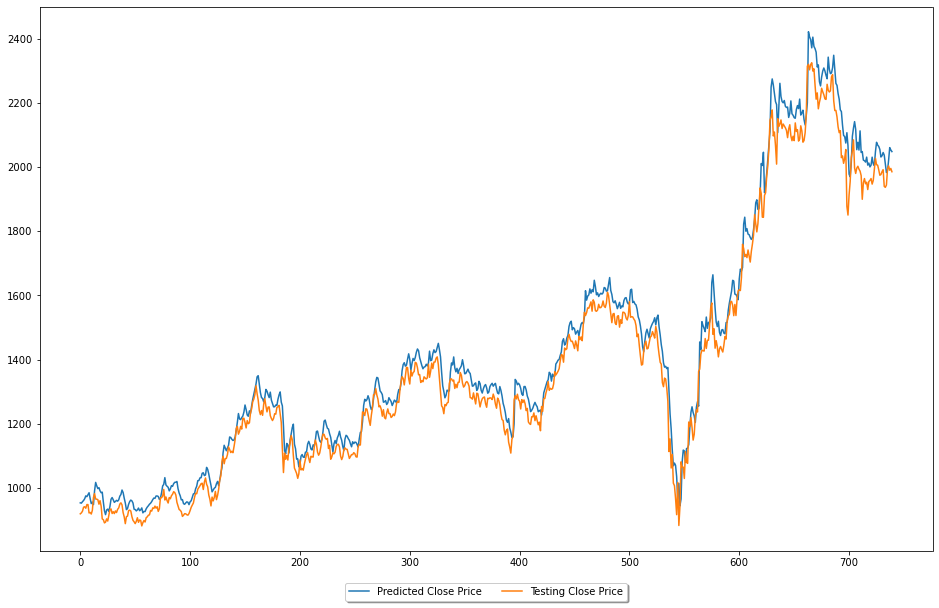

In [39]:
plt.figure(figsize=(16,10))
plt.plot(predictions, label="Predicted Close Price")
plt.plot([row[0] for row in y_test], label="Testing Close Price")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
plt.show()